In [1]:
%matplotlib inline
import os
import cPickle as pkl
import numpy as np
import pandas as pd
import colorsys
import matplotlib.colors as mc
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.patheffects as path_effects
import seaborn as sns
import common.metrics as met
import common.plots as plo
import logging
import lasagne_nn.log_parser as lp
import json
from itertools import izip

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# data handling

def get_preds(data_dict, expt, dset, fold, ratio=None):
    indir = data_dict[expt]["indir"]
    if ratio is not None:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, ratio, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, ratio, dset, fold)
    else:
        knowns_file = data_dict[expt]["knowns_fmt"].format(indir, dset, fold)
        preds_file = data_dict[expt]["preds_fmt"].format(indir, dset, fold)
        
    prediction = np.load(preds_file)
    truth = np.load(knowns_file)
    
    if data_dict[expt]["npz_fmt"] == True:
        prediction = prediction["arr_0"]
        truth = truth["arr_0"]
        
    return prediction, truth

def get_kde_dataframe(expts, data_dict, set_ratio=None, dset="drugmatrix"):
    new_df = pd.DataFrame({"prediction":[], "truth": [], "expt":[], "dset":[], "fold":[]})
    for e in expts:
        for fold in np.arange(0,5,1):
            ratio = None
            if set_ratio is not None:
                ratio = set_ratio
            if not set_ratio and "scrambled" in e:
                ratio = "1.0"
            prediction, truth = get_preds(data_dict, e, dset, fold, ratio=ratio)
            tmp = pd.DataFrame({"prediction": prediction.ravel().copy(), "truth": truth.ravel().copy(), "expt":e, "dset": dset, "fold": fold})
            new_df = new_df.append(tmp)
    return new_df

In [3]:
from matplotlib import pylab

def plot_expt_kdes(df, palette_map, linspace=True, min_cutoff=5.0, max_cutoff=None, percentile_cutoffs=True,
                   n_kdes=20,kde_kws=None, figsize=(15,5), percentile_cutoff=99, 
                   min_percentile_cutoff=50):
    
    sns.set_context("talk")
    plt.figure(figsize=figsize)
    
    for j in range(len(palette_map)):
        curr_expt = palette_map[j][0]
        outer_tmp_df = df[df.expt == curr_expt ].copy()
        outer_tmp_df[outer_tmp_df.truth.notnull()]
        
        if percentile_cutoffs:
            max_cutoff = np.percentile(outer_tmp_df.prediction, percentile_cutoff)
            min_cutoff = np.percentile(outer_tmp_df.prediction, min_percentile_cutoff)
        if linspace:
            cutoffs = np.linspace(min_cutoff, max_cutoff, n_kdes)
        else: 
            cutoffs = np.geomspace(min_cutoff, max_cutoff, n_kdes)
            
        palette_ctr = 0
        
        for i in cutoffs:
            inner_tmp_df = outer_tmp_df[outer_tmp_df.prediction >= i].copy()
            g = sns.distplot(inner_tmp_df.truth, kde=True, hist=False, 
                             kde_kws=kde_kws, color=palette_map[j][1][palette_ctr], label = "{}".format(curr_expt))
            sns.rugplot(a=[inner_tmp_df.truth.median()], colors=[palette_map[j][1][palette_ctr]],
                       linewidth=4.0, alpha=0.9, height=0.1)
            palette_ctr += 1  
            
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    labelsize=30
    titlesize=40
    num_legend_columns=1 
    legend_bbox=(1,1)
    legend_fontsize="small"
    n_lines = len(labels)
    new_handles = [handles[(n_lines/2)-1], handles[-1]]
    new_labels = [labels[(n_lines/2)-1], labels[-1]]
    pylab.legend(new_handles, new_labels, loc=2, 
                 fontsize=legend_fontsize,bbox_to_anchor=legend_bbox, ncol=num_legend_columns)
#     ax.legend()
    return handles, labels

In [4]:
reg_data_file = "../regression/regression_preds_file_lookup.pkl"
with open(reg_data_file, "rb") as f:
    reg_data_dict = pkl.load(f)
    
class_data_file = "../classification/classification_preds_file_lookup.pkl"
with open(class_data_file, "rb") as f:
    class_data_dict = pkl.load(f)

with open("../regression/color_dict_pt.pkl", "rb") as f: 
    color_dict_pt = pkl.load(f)
with open("../regression/color_dict_bar.pkl", "rb") as f: 
    color_dict_bar = pkl.load(f)
    
expt_color_lookup = {
"NEG_RM": "NEG_RM",
"STD": "STD",
"NEG_RM_SMA": "NEG_RM_SMA",
"STD_SMA": "STD_SMA",
"scrambled_idx": "scrambled_idx",
"SEA_SMA": "SEA_SMA",
"scrambled_idx_no_SMA": "scrambled_idx_no_SMA",
"CLASSIFIER_SEA_SMA": "SEA_SMA",
"CLASSIFIER_NEG_RM_SMA_RATIOS_LR03":  "NEG_RM_SMA",
"CLASSIFIER_SMA_RATIOS_LR03": "STD_SMA",
"CLASSIFIER_scrambled_idx_LR03": "scrambled_idx",
"CLASSIFIER_scrambled_idx_No_SMA_LR03": "scrambled_idx_no_SMA",
"CLASSIFIER_STD_LR03": "STD", }

In [5]:
n_kdes = 30
class_min = 0.5
reg_min = 5.0
percentile_cutoff = 99

class_expts = ["CLASSIFIER_SMA_RATIOS_LR03",  "CLASSIFIER_STD_LR03", ]
class_kde_df = get_kde_dataframe(class_expts, class_data_dict, set_ratio=1.0)

reg_expts = ["STD", "STD_SMA", ]
reg_kde_df = get_kde_dataframe(reg_expts, reg_data_dict, set_ratio=None)

class_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes)) for i in class_expts]
reg_palettes = [(i, 
                 sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes)) for i in reg_expts]

for i in range(len(class_palettes)):
    class_palettes[i][1].sort(reverse=True)
for i in range(len(reg_palettes)):
    reg_palettes[i][1].sort(reverse=True)
    
kde_kws = {"linewidth":3.0, "alpha":0.75}

CLASSIFIER_SMA_RATIOS_LR03
CLASSIFIER_STD_LR03


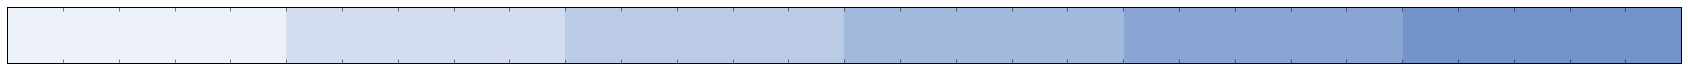

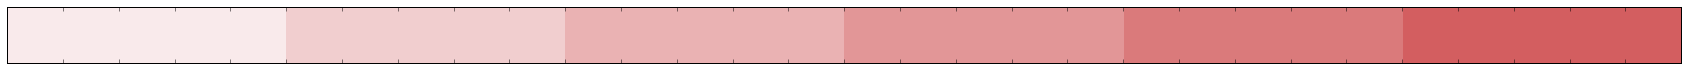

In [6]:
print(class_palettes[0][0])
sns.palplot(class_palettes[0][1])
print(class_palettes[1][0])
sns.palplot(class_palettes[1][1])

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


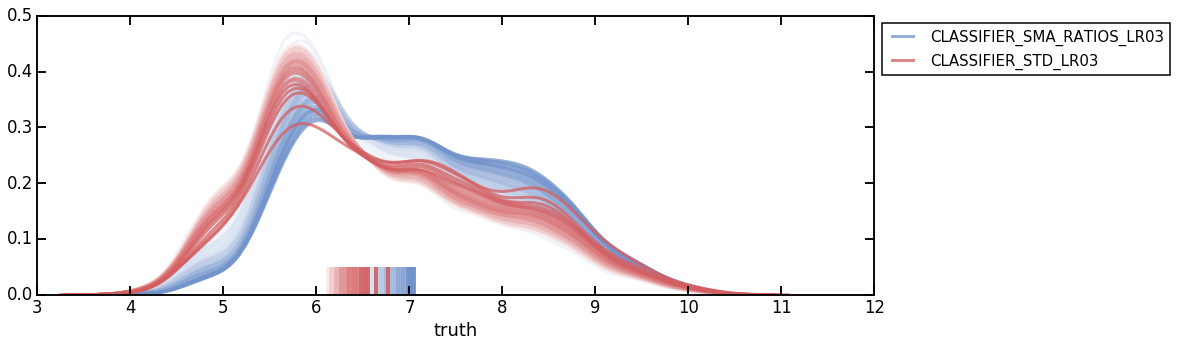

In [7]:
percentile_cutoff=95
h, l = plot_expt_kdes(class_kde_df, class_palettes, linspace=True, min_cutoff=class_min,
               n_kdes=n_kdes, kde_kws=kde_kws, figsize=(15,5),
               percentile_cutoff=percentile_cutoff) 

STD
STD_SMA


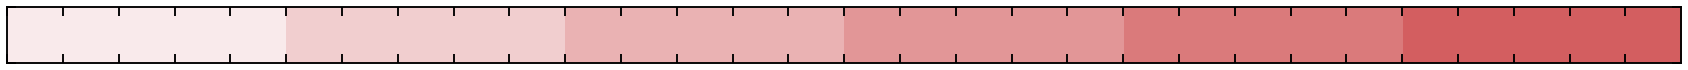

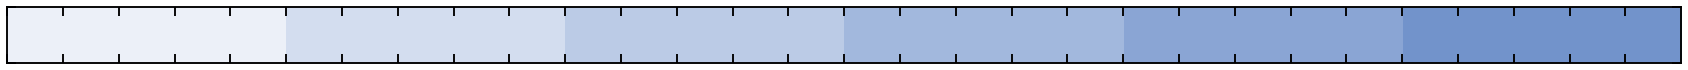

In [8]:
print(reg_palettes[0][0])
sns.palplot(reg_palettes[0][1])
print(reg_palettes[1][0])
sns.palplot(reg_palettes[1][1])

([<matplotlib.lines.Line2D at 0x7f290ea558d0>,
 [u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA',
  u'STD_SMA'])

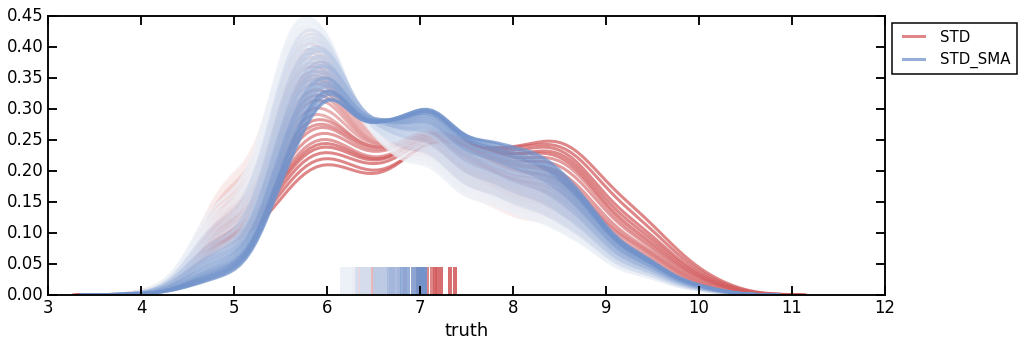

In [9]:
plot_expt_kdes(reg_kde_df, reg_palettes, linspace=True, min_cutoff=reg_min, 
               n_kdes=n_kdes, kde_kws=kde_kws, figsize=(15,5), 
               percentile_cutoff=percentile_cutoff) 

SMA makes regression predictions more conservative on drugmatrix as evidenced by both tails moving closer to the median.

**Check mean absolute vs mean squared error.**

Supplement is later, but we want a table of number of observations per percentile cutoff & means.

## What happens with the scrambled?


In [10]:
n_kdes=50
percentile_cutoff=99
min_percentile_cutoff = 50
kde_kws = {"linewidth":3.0, "alpha":0.6}

class_expts = [ "CLASSIFIER_scrambled_idx_LR03", "CLASSIFIER_scrambled_idx_No_SMA_LR03",]
class_kde_df = get_kde_dataframe(class_expts, class_data_dict, set_ratio=1.0)

reg_expts = [ "scrambled_idx_no_SMA", "scrambled_idx", ]
reg_kde_df = get_kde_dataframe(reg_expts, reg_data_dict, set_ratio=None)

class_palettes = [(i, 
                   sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes+1)) for i in class_expts]
reg_palettes = [(i, 
                 sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes+1)) for i in reg_expts]

for i in range(len(class_palettes)):
    class_palettes[i][1].sort(reverse=True)
for i in range(len(reg_palettes)):
    reg_palettes[i][1].sort(reverse=True)

([<matplotlib.lines.Line2D at 0x7f290e128b50>,
 [u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_scrambled_idx_LR03',
  u'CLASSIFIER_sc

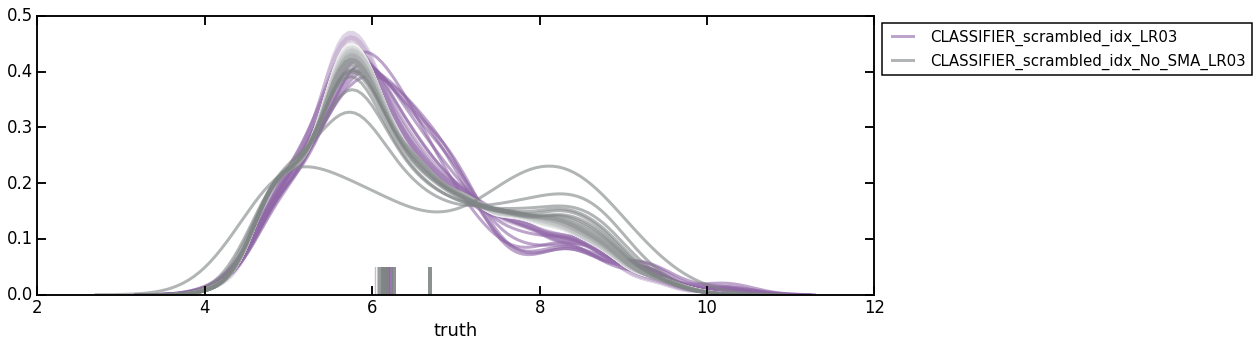

In [11]:
plot_expt_kdes(class_kde_df, class_palettes, 
               linspace=True, 
               n_kdes=n_kdes, 
               kde_kws=kde_kws,
               figsize=(15,5), 
               percentile_cutoff=percentile_cutoff,
              min_percentile_cutoff=min_percentile_cutoff,) 

scrambled_idx_no_SMA
scrambled_idx


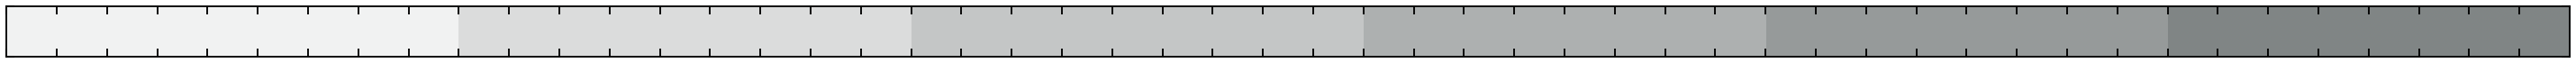

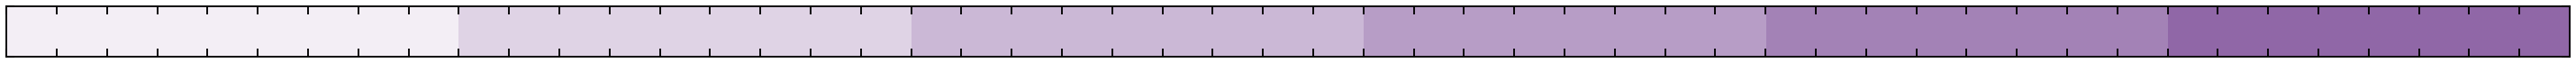

In [12]:
print(reg_palettes[0][0])
sns.palplot(reg_palettes[0][1])
print(reg_palettes[1][0])
sns.palplot(reg_palettes[1][1])

([<matplotlib.lines.Line2D at 0x7f290c6ff9d0>,
 [u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scrambled_idx_no_SMA',
  u'scra

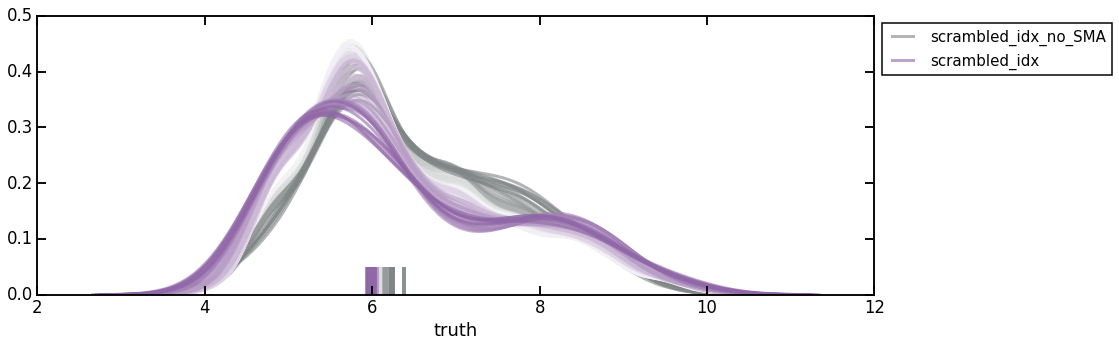

In [13]:
plot_expt_kdes(reg_kde_df, reg_palettes, linspace=True,
               min_cutoff=reg_min, 
               min_percentile_cutoff=min_percentile_cutoff,
               n_kdes=n_kdes, 
               kde_kws=kde_kws, 
               figsize=(15,5), 
               percentile_cutoff=percentile_cutoff) 

## Comparison to scrambled

In [14]:
n_kdes = 30
class_min = 0.5
reg_min = 5.0
percentile_cutoff = 99

class_expts = ["CLASSIFIER_SMA_RATIOS_LR03",  "CLASSIFIER_scrambled_idx_LR03",  ]
class_kde_df = get_kde_dataframe(class_expts, class_data_dict, set_ratio=1.0)

reg_expts = [ "STD_SMA", "scrambled_idx",]
reg_kde_df = get_kde_dataframe(reg_expts, reg_data_dict, set_ratio=None)

class_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes+1)) for i in class_expts]
reg_palettes = [(i, 
                 sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes+1)) for i in reg_expts]

for i in range(len(class_palettes)):
    class_palettes[i][1].sort(reverse=True)
for i in range(len(reg_palettes)):
    reg_palettes[i][1].sort(reverse=True)
    
kde_kws = {"linewidth":3.0, "alpha":0.7}

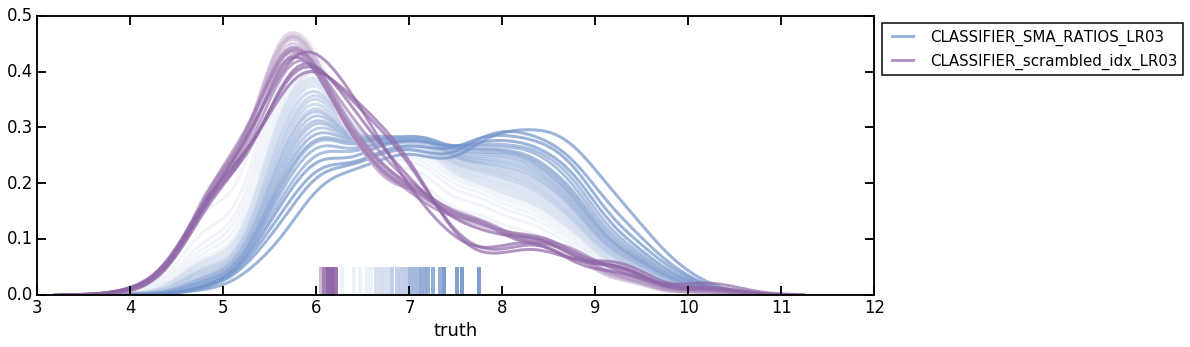

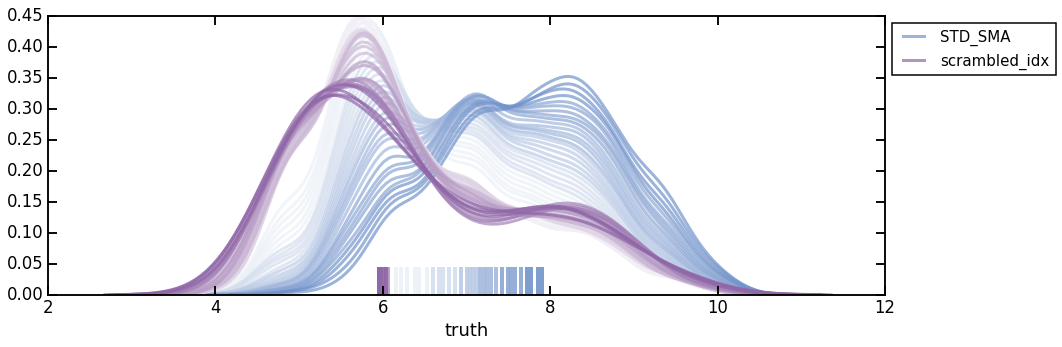

In [15]:
plot_expt_kdes(class_kde_df, class_palettes, 
               linspace=True, 
               n_kdes=n_kdes, 
               kde_kws=kde_kws,
               figsize=(15,5), 
               percentile_cutoff=percentile_cutoff,
              min_percentile_cutoff=min_percentile_cutoff,) 
plt.show()
plot_expt_kdes(reg_kde_df, reg_palettes, linspace=True,
               min_cutoff=reg_min, 
               min_percentile_cutoff=min_percentile_cutoff,
               n_kdes=n_kdes, 
               kde_kws=kde_kws, 
               figsize=(15,5), 
               percentile_cutoff=percentile_cutoff) 
plt.show()

In [16]:
n_kdes = 30
class_min = 0.5
reg_min = 5.0
percentile_cutoff = 99

class_expts = ["CLASSIFIER_STD_LR03", "CLASSIFIER_scrambled_idx_No_SMA_LR03",]
class_kde_df = get_kde_dataframe(class_expts, class_data_dict, set_ratio=1.0)

reg_expts = [ "STD", "scrambled_idx_no_SMA",]
reg_kde_df = get_kde_dataframe(reg_expts, reg_data_dict, set_ratio=None)

class_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes+1)) for i in class_expts]
reg_palettes = [(i, 
                 sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes+1)) for i in reg_expts]

for i in range(len(class_palettes)):
    class_palettes[i][1].sort(reverse=True)
for i in range(len(reg_palettes)):
    reg_palettes[i][1].sort(reverse=True)
    
kde_kws = {"linewidth":3.0, "alpha":0.7}

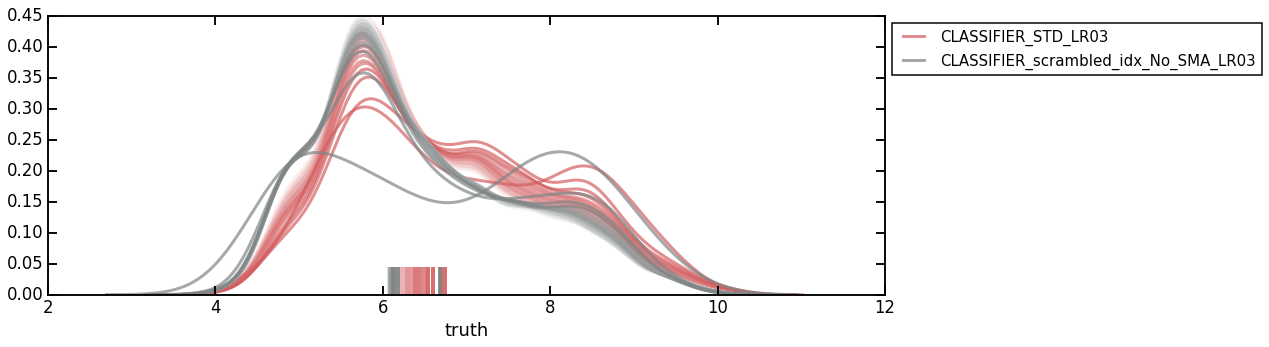

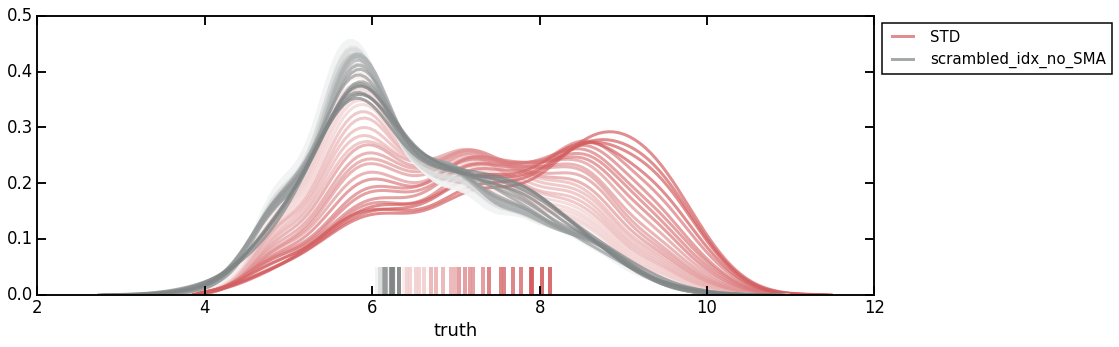

In [17]:
plot_expt_kdes(class_kde_df, class_palettes, 
               linspace=True, 
               n_kdes=n_kdes, 
               kde_kws=kde_kws,
               figsize=(15,5), 
               percentile_cutoff=percentile_cutoff,
              min_percentile_cutoff=min_percentile_cutoff,) 
plt.show()
plot_expt_kdes(reg_kde_df, reg_palettes, linspace=True,
               min_cutoff=reg_min, 
               min_percentile_cutoff=min_percentile_cutoff,
               n_kdes=n_kdes, 
               kde_kws=kde_kws, 
               figsize=(15,5), 
               percentile_cutoff=percentile_cutoff) 
plt.show()

In [18]:
n_kdes = 10
class_min = 0.5
reg_min = 5.0
percentile_cutoff = 99

class_expts = ["CLASSIFIER_SMA_RATIOS_LR03",  "CLASSIFIER_STD_LR03", ]
class_kde_df = get_kde_dataframe(class_expts, class_data_dict, set_ratio=1.0, dset="timesplit")

reg_expts = [ "STD_SMA", "STD",]
reg_kde_df = get_kde_dataframe(reg_expts, reg_data_dict, set_ratio=None, dset="timesplit")

class_palettes = [(i, 
                sns.color_palette(sns.light_palette(color_dict_bar[expt_color_lookup[i]]), n_kdes+1)) for i in class_expts]
reg_palettes = [(i, 
                 sns.color_palette(sns.light_palette(color_dict_bar[i]), n_kdes+1)) for i in reg_expts]

for i in range(len(class_palettes)):
    class_palettes[i][1].sort(reverse=True)
for i in range(len(reg_palettes)):
    reg_palettes[i][1].sort(reverse=True)
    
kde_kws = {"linewidth":3.0, "alpha":0.7}

KeyboardInterrupt: 

In [ ]:
plot_expt_kdes(class_kde_df, class_palettes, linspace=True, min_cutoff=class_min,
               n_kdes=n_kdes, kde_kws=kde_kws, figsize=(15,5), percentile_cutoff=percentile_cutoff)
plot_expt_kdes(reg_kde_df, reg_palettes, linspace=True, min_cutoff=reg_min, 
               n_kdes=n_kdes, kde_kws=kde_kws, figsize=(15,5), percentile_cutoff=percentile_cutoff) 